In [2]:
import os
import h5py as h5
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
import numpy as np
from tqdm.notebook import tqdm
import torch

try:
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError: 
    !pip install --quiet gwpy
    from gwpy.timeseries import TimeSeries

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f"TORCH DEVICE: {device}")

TORCH DEVICE: cuda


In [4]:
def construct_dataframe(path,t_delta=None):
  name_data=[]
  starting_times_data=[]
  timeseries_data=[]
  type_data=[]
  for file in listdir(path):
    if file != '.ipynb_checkpoints':
        fout=h5.File(path+file,'r') 
    type_of_glitch=list(fout.keys())[0]
    dataset=fout[type_of_glitch]
    t = TimeSeries(dataset[()])
    ln=len(t)/2
    #if no t_delta is provided, the whole the timeseries are not cut 
    if t_delta==None:
      t_delta=ln
    name_data.append(file.split('.')[0].split('_')[0])
    type_data.append(type_of_glitch)
    starting_times_data.append(dataset.attrs['t0'])
    dataset_cut=dataset[()][int(ln-t_delta):int(ln+t_delta)]
    timeseries_data.append(dataset_cut)
    # intialise data of lists.

  data_Virgo = {'ID':name_data,
        'Type_Of_Glitch':type_data,
        'Starting_Times':starting_times_data,
        'TimeSeries':timeseries_data}
    # Create DataFrame
  df= pd.DataFrame(data_Virgo)
  return df

In [5]:
path1="/kaggle/input/blips-glitchs/H1_O2_Blip_0-2000/content/sample_data/H1_O2_Blip_0-2000/"
path2="/kaggle/input/blips-glitchs/H1_O2_Blip_4000-7000/content/sample_data/H1_O2_Blip_4000-7000/"
path3="/kaggle/input/blips-glitchs/H1_O2_Blip_7000-10000/content/sample_data/H1_O2_Blip_7000-10000/"

In [6]:
df1=construct_dataframe(path1)
df2=construct_dataframe(path2)
df3=construct_dataframe(path3)

In [7]:
df=pd.concat([df1, df2, df3], ignore_index=True)

In [8]:
tmseries=df['TimeSeries'].values
tmseries.shape

(6857,)

In [93]:
data=[]
for element in tmseries:
    if len(element)==938:
        data.append(element)
data=np.asarray(data)
data.shape

(6736, 938)

In [10]:
data_min, data_max = data.min(1).reshape((data.shape[0],1)), data.max(1).reshape((data.shape[0],1))
new_min, new_max = -1.0, 1.0

In [40]:
def norm_func(data,new_min=-1.0,new_max=1.0):
    data_min, data_max = data.min(1).reshape((data.shape[0],1)), data.max(1).reshape((data.shape[0],1))
    return (data - data_min)/(data_max - data_min)*(new_max - new_min) + new_min

In [11]:
#data = (data - data_min)/(data_max - data_min)*(new_max - new_min) + new_min

In [94]:
data= (data-data.mean(-1).reshape(-1,1))/data.std(-1).reshape(-1,1)

In [89]:
#data= (data-data.mean(0).reshape(1,-1))/data.std(0).reshape(1,-1)

In [90]:
#data=data/data.max(1).reshape((data.shape[0],1))

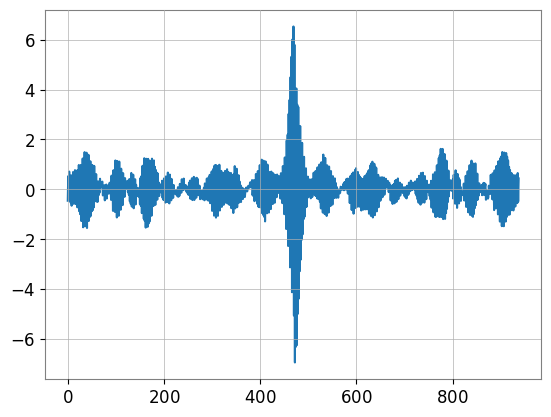

In [95]:
plt.plot(data[9])

In [96]:
#data=(data-data.mean(-1).reshape((data.shape[0],1)))/data.std(-1).reshape((data.shape[0],1))

In [98]:
train_val_split=1000
batch_size=256
train_loader = torch.utils.data.DataLoader(torch.tensor(data[:-train_val_split]), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.tensor(data[-train_val_split:]), batch_size=batch_size, shuffle=True)

# Flow

In [56]:
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal

In [57]:
class OLDAffineCouplingLayer(nn.Module):
    def __init__(self, in_features):
        super(AffineCouplingLayer, self).__init__()
        self.scale = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.Tanh()
        )       
        self.scale2 = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.Tanh()
        )
        self.shift = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features)
        )
        self.shift2 = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features)
        )
        self.mask = self.checkerboard_mask(in_features)
    
    def forward(self, x):
        x1, x2 = self.mask*x, (1-self.mask)*x
        s = (1-self.mask)*(self.scale(x1))
        t = (1-self.mask)*self.shift(x1)
        x2 = x2 * torch.exp(s) + t
        log_det = s.sum(dim=1)
        
        s = self.mask*(self.scale(x2))
        t = self.mask*self.shift(x2)
        x1 = x1 * torch.exp(s) + t
        
        x = x1+x2
        log_det += s.sum(dim=1)
        
        
        return x, log_det
    
    def inverse(self, z):
        z1, z2 = self.mask*z, (1-self.mask)*z
        s = self.mask*(self.scale2(z2))
        t = self.mask*self.shift2(z2)
        x1 = (z1 - t) * torch.exp(-s)
        log_det = -s.sum(dim=1)
        
        s = (1-self.mask)*(self.scale(z1))
        t = (1-self.mask)*self.shift(z1)
        x2 = (z2 - t) * torch.exp(-s)
      
        x = x1+x2
        log_det -= s.sum(dim=1)
        return x, log_det
    
    def checkerboard_mask(self, size):
        mask = torch.zeros(1, size).to(device)
        mask[:, ::2] = 1
        return mask

In [58]:
'''        self.net1 = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, 2*in_features),
            #nn.Tanh()
        )       
        self.net2 = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, 2*in_features),
            #nn.Tanh()
        )
        self.net1 = nn.Sequential( #Non male
            nn.Conv1d(1, 32,33,1,33//2),
            nn.Conv1d(32, 2,3,1,3//2),
        )       
        self.net2 = nn.Sequential(
            nn.Conv1d(1, 32,33,1,33//2),
            nn.Conv1d(32, 2,3,1,3//2),
        ) 
        
        self.net1 = nn.Sequential( #Non male
            nn.Conv1d(1, 32,3,1,3//2),
            nn.Conv1d(32, 32,3,1,3//2),
            nn.Conv1d(32, 32,3,1,3//2),
            nn.Conv1d(32, 2,3,1,3//2),
        )       
        self.net2 = nn.Sequential(
            nn.Conv1d(1, 32,3,1,3//2),
            nn.Conv1d(32, 32,3,1,3//2),
            nn.Conv1d(32, 32,3,1,3//2),
            nn.Conv1d(32, 2,3,1,3//2),
        )      '''

'        self.net1 = nn.Sequential(\n            nn.Linear(in_features, in_features),\n            nn.ReLU(),\n            nn.Linear(in_features, in_features),\n            nn.ReLU(),\n            nn.Linear(in_features, in_features),\n            nn.ReLU(),\n            nn.Linear(in_features, 2*in_features),\n            #nn.Tanh()\n        )       \n        self.net2 = nn.Sequential(\n            nn.Linear(in_features, in_features),\n            nn.ReLU(),\n            nn.Linear(in_features, in_features),\n            nn.ReLU(),\n            nn.Linear(in_features, in_features),\n            nn.ReLU(),\n            nn.Linear(in_features, 2*in_features),\n            #nn.Tanh()\n        )\n        self.net1 = nn.Sequential( #Non male\n            nn.Conv1d(1, 32,33,1,33//2),\n            nn.Conv1d(32, 2,3,1,3//2),\n        )       \n        self.net2 = nn.Sequential(\n            nn.Conv1d(1, 32,33,1,33//2),\n            nn.Conv1d(32, 2,3,1,3//2),\n        ) \n        \n        self.net

In [59]:
class DLinear(torch.nn.Module):
    def __init__(self, input_shape, output_shape,kernel_size=25):
        #Works only for odd kernel
        super(DLinear, self).__init__()
        padding=kernel_size//2
        self.layer1=torch.nn.Linear(input_shape,output_shape)
        self.layer2=torch.nn.Linear(input_shape,output_shape)
        self.pooling=torch.nn.AvgPool1d(kernel_size,stride=1)
        self.pad=torch.nn.ConstantPad1d(padding, 0)
        
    def forward(self,x):
        x_trend=self.pooling(self.pad(x))
        x=x-x_trend
        x,x_trend=self.layer1(x),self.layer2(x_trend)
        return x+x_trend

In [60]:
class Net(nn.Module):
    def __init__(self, in_features):
        super(Net, self).__init__()
        self.layer1= nn.Conv1d(1, 1,33,1,33//2)
        #self.layer2= nn.Conv1d(32, 1,3,1,3//2)
        self.linear = nn.Linear(in_features, 2*in_features)
        torch.nn.init.zeros_(self.linear.weight)
        
    def forward(self,x):
        x=x-self.layer1(x)
        x=self.linear(x)
        return x

In [99]:
class Net2(nn.Module):
    def __init__(self, in_features):
        super(Net2, self).__init__()
        self.layer1= nn.Conv1d(1, 1,25,1,25//2)
        self.layer2= nn.Conv1d(1, 1,9,1,9//2)
        self.layer3 = nn.Conv1d(3,1,3,1,3//2)
        self.linear = nn.Linear(in_features, 2*in_features)
        torch.nn.init.zeros_(self.linear.weight)
        
    def forward(self,x):
        x0=x
        xt=self.layer1(x)
        xs=self.layer2(x)
        x=torch.cat([x,x-xt,x-xs],1)
        x=self.layer3(x)
        x=self.linear(x0+x)
        return x

In [110]:
class Net2(nn.Module):
    def __init__(self, in_features):
        super(Net2, self).__init__()
        self.layer1= nn.Conv1d(1, 1,25,1,25//2)
        self.layer2= nn.Conv1d(1, 1,9,1,9//2)
        self.layer5= nn.Conv1d(1, 1,3,1,3//2)
        self.layer3 = nn.Conv1d(4,32,5,1,5//2)
        self.layer4 = nn.Conv1d(32,1,3,1,3//2)
        self.linear = nn.Linear(in_features, 2*in_features)
        torch.nn.init.zeros_(self.linear.weight)
        
    def forward(self,x):
        x0=x
        xt=self.layer1(x)
        xs=self.layer2(x)
        xs1=self.layer5(x)
        x=torch.cat([x,x-xt,x-xs,xs1],1)
        x=self.layer3(x)
        x=torch.relu(x)
        x=self.layer4(x)
        x=self.linear(x0+x)
        return x

In [111]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, in_features):
        super(AffineCouplingLayer, self).__init__()
        self.net1 = Net2(in_features)
        self.net2 = Net2(in_features)#DLinear(in_features,in_features)
        self.mask = self.checkerboard_mask(in_features)
        self.in_size = in_features
        #torch.nn.init.zeros_(self.net1[-1].weight)
        #torch.nn.init.zeros_(self.net2[-1].weight)
    
    def forward(self, x):
        x1, x2 = self.mask*x, (1-self.mask)*x
        s,t= self.net1(x1.unsqueeze(1)).view(2,-1,self.in_size)
        s = (1-self.mask)*torch.tanh(s)
        t = (1-self.mask)*t
        x2 = x2 * torch.exp(s) + t
        log_det = s.sum(dim=1)
        
        s,t= self.net2(x2.unsqueeze(1)).view(2,-1,self.in_size)
        s = self.mask*torch.tanh(s)
        t = self.mask*t
        x1 = x1 * torch.exp(s) + t
        
        x = x1+x2
        log_det += s.sum(dim=1)
        
        return x, log_det
    
    def inverse(self, z):
        z1, z2 = self.mask*z, (1-self.mask)*z
        s,t= self.net1(z2.unsqueeze(1)).view(2,-1,self.in_size)
        s = (1-self.mask)*torch.tanh(s)
        t = (1-self.mask)*t
        z1 = (z1 - t) * torch.exp(-s)
        log_det = -s.sum(dim=1)
        
        s,t= self.net2(z1.unsqueeze(1)).view(2,-1,self.in_size)
        s = self.mask*torch.tanh(s)
        t = self.mask*t
        z2 = (z2 - t) * torch.exp(-s)
      
        z = z1+z2
        log_det -= s.sum(dim=1)
        return z, log_det
    
    def checkerboard_mask(self, size):
        mask = torch.zeros(1, size).to(device)
        mask[:, ::2] = 1
        return mask

In [112]:
class RescaleLayer(nn.Module):
    def __init__(self, in_features):
        super(RescaleLayer, self).__init__()
        self.scale = nn.Parameter(torch.ones(1, in_features), requires_grad=True)

    def forward(self, x):
        z = x * self.scale
        log_det = torch.sum(torch.log(torch.abs(self.scale)),-1)
        return z,torch.ones(x.shape[0]).to(device)* log_det

    def inverse(self, z):
        x = z / self.scale
        log_det = -torch.sum(torch.log(torch.abs(self.scale)),-1)
        return x,torch.ones(x.shape[0]).to(device)* log_det

In [113]:
class NormalizingFlow(nn.Module):
    def __init__(self, num_layers, in_features):
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList([AffineCouplingLayer(in_features) for _ in range(num_layers)])#+[RescaleLayer(in_features)])
    def forward(self, x):
        log_det = 0
        for layer in self.layers:
            x, ld = layer(x)
            log_det += ld
        return x, log_det
    
    def inverse(self, x):
        log_det = 0
        for layer in reversed(self.layers):
            x, ld = layer.inverse(x)
            log_det += ld
        return x, log_det

    

In [114]:
def train(epoch,net,optimizer, base_distribution, train_loader, val_loader,scheduler):
    for epoch in tqdm(range(epoch)):
        #clear_output(wait=True)
        train_loss = 0
        for i, data in enumerate(train_loader, 0):
            #inputs, target = data[:,:data_split],data[:,data_split:]
            optimizer.zero_grad()
            x, log_det = net(data.to(device))
            loss = -base_distribution.log_prob(x).mean() - log_det.mean()
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            train_loss += loss.item()
            
        validation_loss=compute_loss(net,val_loader,base_distribution)
        print('Epoch %d, train loss: %.5f, validation loss: %.5f' %
              (epoch + 1, train_loss / len(train_loader), validation_loss))
    print('Finished Training')
    
def compute_loss(net,loader,base_distribution):
    with torch.no_grad():
        running_loss=0
        for data in loader:
            x, log_det = net(data.to(device))
            loss = -base_distribution.log_prob(x).mean() - log_det.mean()
            running_loss+=loss.item()
    return running_loss/len(loader)        

In [115]:
num_layers = 10
in_features = 938
net = NormalizingFlow(num_layers, in_features).to(device)
base_distribution = MultivariateNormal(torch.zeros(in_features).to(device), torch.eye(in_features).to(device))
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.92, patience=100, min_lr=1e-7)
# Training loop
epoch = 1000

In [116]:
train(epoch,net,optimizer, base_distribution, train_loader, val_loader,scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, train loss: 1071.07270, validation loss: 1022.05663
Epoch 2, train loss: 1025.63179, validation loss: 1014.17490
Epoch 3, train loss: 1019.37489, validation loss: 1010.86467
Epoch 4, train loss: 1014.83679, validation loss: 1004.96010
Epoch 5, train loss: 1006.30673, validation loss: 994.42621
Epoch 6, train loss: 991.80023, validation loss: 972.99060
Epoch 7, train loss: 970.85396, validation loss: 950.43292
Epoch 8, train loss: 953.02069, validation loss: 937.29124
Epoch 9, train loss: 943.54039, validation loss: 930.07986
Epoch 10, train loss: 938.25094, validation loss: 927.98154
Epoch 11, train loss: 936.04188, validation loss: 923.13719
Epoch 12, train loss: 934.62402, validation loss: 921.33551
Epoch 13, train loss: 932.51923, validation loss: 919.21446
Epoch 14, train loss: 930.40495, validation loss: 919.93347
Epoch 15, train loss: 930.18434, validation loss: 918.71246
Epoch 16, train loss: 929.41232, validation loss: 919.06740
Epoch 17, train loss: 928.46820, validat

KeyboardInterrupt: 

In [117]:
samples = (net.inverse(base_distribution.sample((100,)))[0]).detach().cpu().numpy()

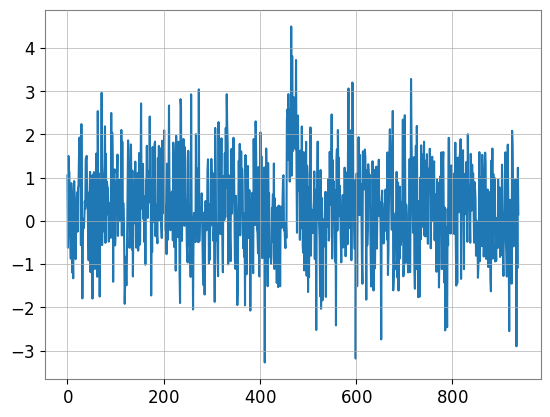

In [118]:
plt.plot(samples[0])#/samples[15].max(-1)[0].detach().cpu().numpy())